In [2]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

Only some of the later work is mine, source: https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/ (published in 2019)

In [3]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [4]:
candidate_sentences['sentence']

0                                                   confused and frustrated, connie decides to leave on her own.
1                                                              later, a woman’s scream is heard in the distance.
2                                                                       christian is then paralyzed by an elder.
3                                                                                     the temple is set on fire.
4                                                                              outside, the cult wails with him.
                                                          ...                                                   
4313       confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent.
4314                                               and le parisien gave the film their highest five-star rating.
4315    the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs a

doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

In [5]:
doc = nlp("Hello, my name is Ojan, what is yours?")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Hello ... intj
, ... punct
my ... poss
name ... nsubj
is ... ROOT
Ojan ... attr
, ... punct
what ... attr
is ... relcl
yours ... nsubj
? ... punct


In [6]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [8]:
get_entities("Today, I was at Mohammads house, and then Hassan and Hussien came too")

['then Mohammads Hassan', 'Mohammads house']

In [9]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:26<00:00, 165.84it/s]


In [10]:
entity_pairs[10:30]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel'],
 ['last  which', 'penn'],
 ['jessica chastain', 'same  character'],
 ['mauro fiore', 'cinematographer'],
 ['filming', 'october'],
 ['soundtrack', 'digitally  june'],
 ['album', 'digitally  august'],
 ['film', 'studios motion pictures'],
 ['it', '$ 103.7 million'],
 ['stars kyle chandler', "o'shea jackson o'shea ."],
 ['it', 'executive producer yoshimitsu banno']]

In [11]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab) # a regex command?

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [12]:
get_relation("I went home and then later I left home")

'went'

In [13]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:24<00:00, 174.77it/s]


In [14]:
pd.Series(relations).value_counts()[:50]

is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

In [15]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [19]:
kg_df

,source,target,edge
0,connie,own,decides
1,woman scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
...,...,...,...
4313,confidencial,barren drama,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


In [16]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

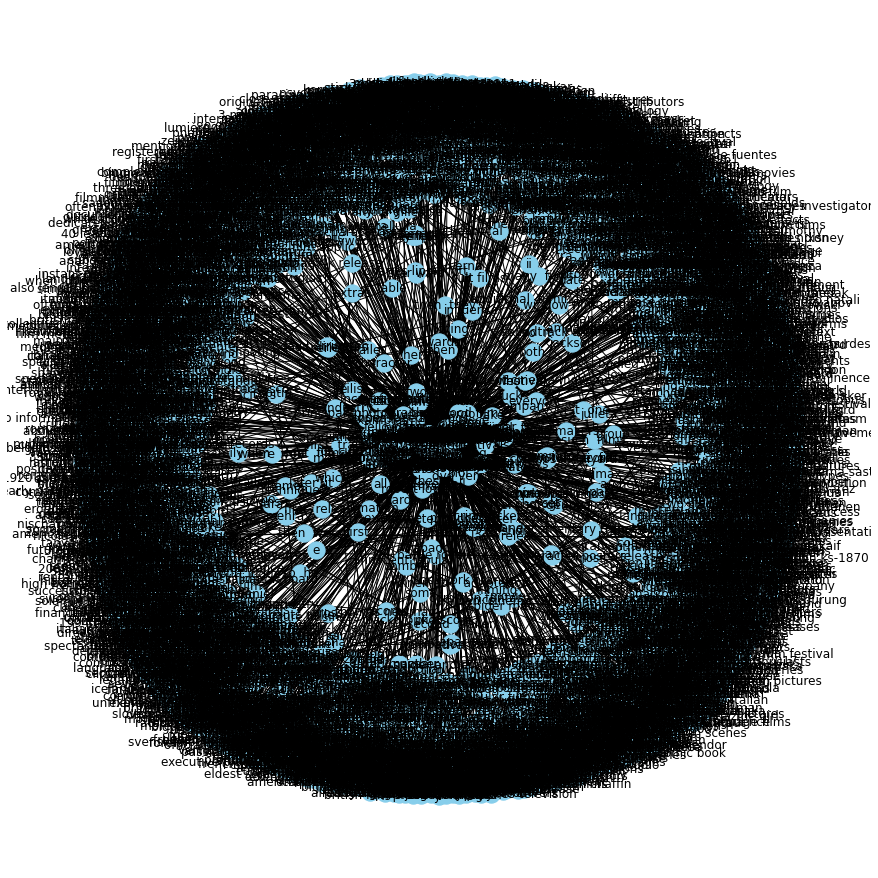

In [17]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

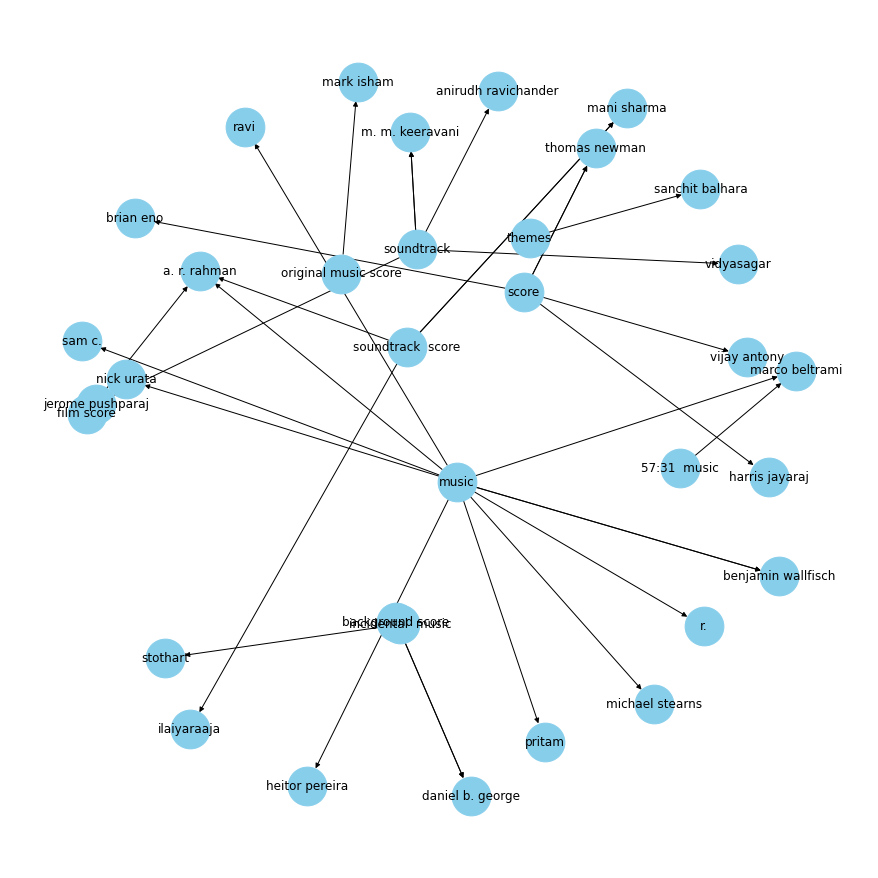

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

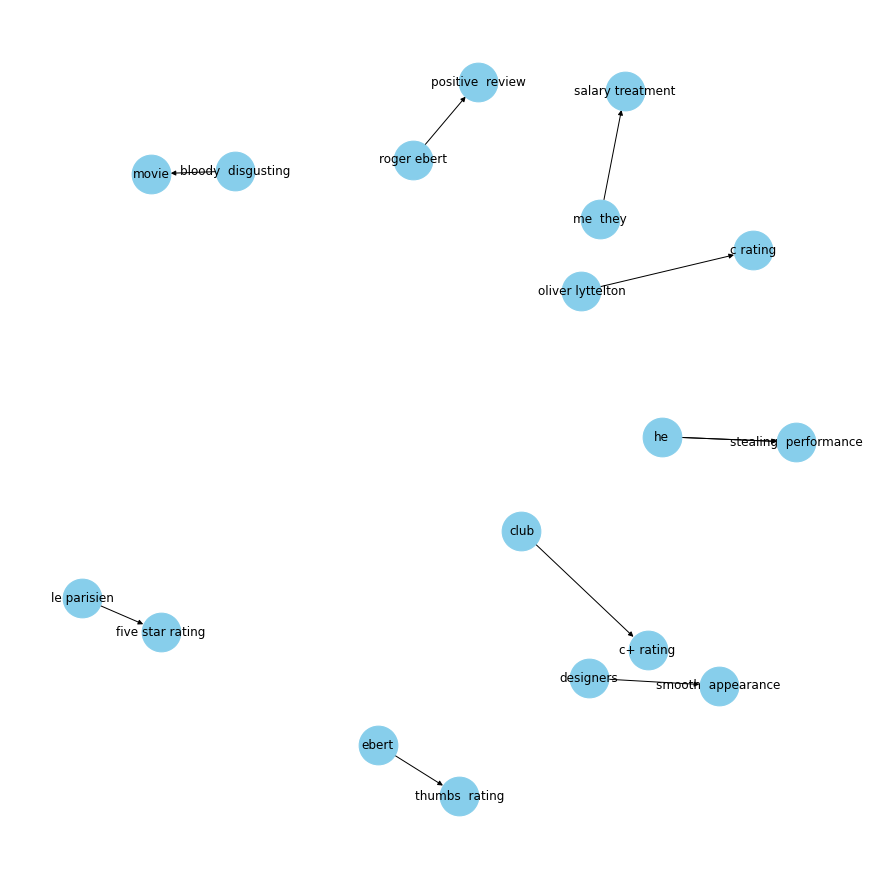

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="gave"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

he
2


DiMultiDegreeView({'club': 1, 'c+ rating': 1, 'oliver lyttelton': 1, 'c rating': 1, 'designers': 1, 'smooth  appearance': 1, 'me  they': 1, 'salary treatment': 1, 'he': 2, 'stealing  performance': 2, 'roger ebert': 1, 'positive  review': 1, 'bloody  disgusting': 1, 'movie': 1, 'ebert': 1, 'thumbs  rating': 1, 'le parisien': 1, 'five star rating': 1})

In [41]:
kg_df['source'].value_counts()

it                 268
film               220
                   173
he                 139
they                70
                  ... 
bryan hirota         1
scanline vfx         1
digital  domain      1
dinosaurs            1
predecessor          1
Name: source, Length: 2179, dtype: int64

In [43]:
sorted(G.degree, key=lambda x: x[1], reverse=True)

[('he', 2),
 ('stealing  performance', 2),
 ('club', 1),
 ('c+ rating', 1),
 ('oliver lyttelton', 1),
 ('c rating', 1),
 ('designers', 1),
 ('smooth  appearance', 1),
 ('me  they', 1),
 ('salary treatment', 1),
 ('roger ebert', 1),
 ('positive  review', 1),
 ('bloody  disgusting', 1),
 ('movie', 1),
 ('ebert', 1),
 ('thumbs  rating', 1),
 ('le parisien', 1),
 ('five star rating', 1)]

In [48]:
G.order()

18

In [49]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="gave"], "source", "target", 
                          edge_attr=True, create_using=nx.Graph())

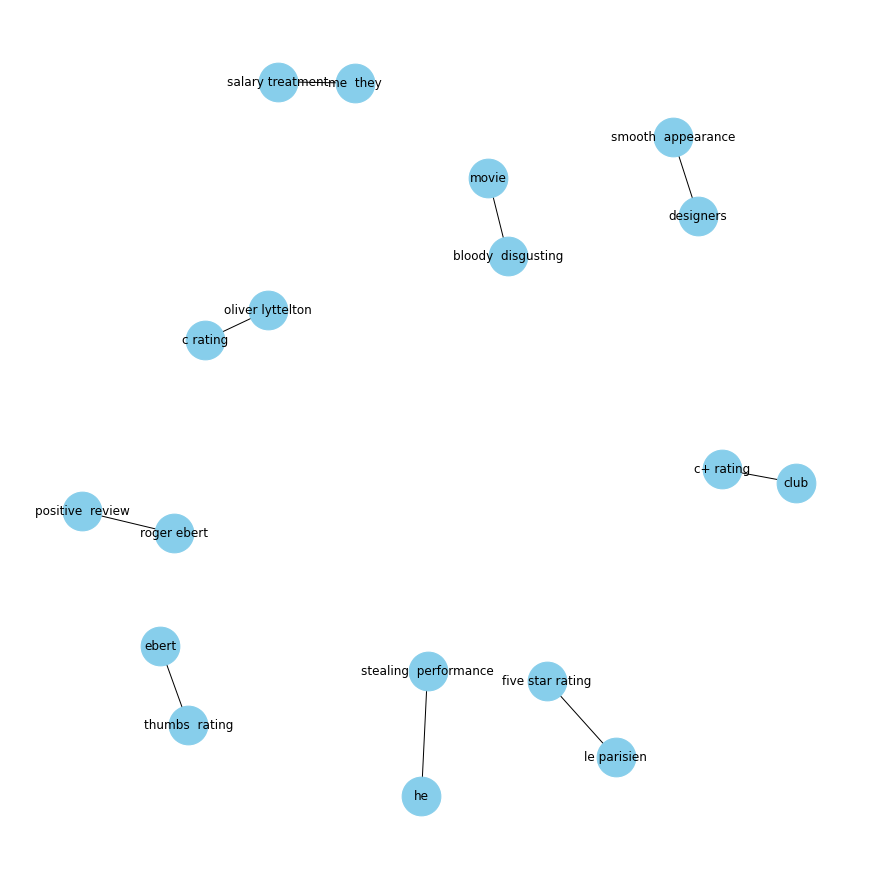

In [50]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [53]:
#checks
bc = nx.betweenness_centrality(G, normalized=False)
bc

{'bloody  disgusting': 0.0,
 'c rating': 0.0,
 'c+ rating': 0.0,
 'club': 0.0,
 'designers': 0.0,
 'ebert': 0.0,
 'five star rating': 0.0,
 'he': 0.0,
 'le parisien': 0.0,
 'me  they': 0.0,
 'movie': 0.0,
 'oliver lyttelton': 0.0,
 'positive  review': 0.0,
 'roger ebert': 0.0,
 'salary treatment': 0.0,
 'smooth  appearance': 0.0,
 'stealing  performance': 0.0,
 'thumbs  rating': 0.0}

In [56]:
gcb = nx.group_betweenness_centrality(G, ['roger ebert'], normalized=True, weight=None, endpoints=False)
gcb

0.0